In [42]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import bdm_duck as bd

# For NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

# For ML & clustering
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

logging.basicConfig(level=logging.INFO, format='%(message)s')

In [19]:
# Print of all available tables in the exploitation zone
print("Available tables in the exploitation zone:")
print(bd.list_tables())

Available tables in the exploitation zone:
['eodhd_financial_news', 'finnhub_financial_report', 'imf_indicators', 'ops_db_kyc_metadata', 'ops_db_user_profiles', 'ops_db_user_transactions']


# Consumption Task 1: News Sentiment and Headline Topics

In [20]:
news = bd.table("eodhd_financial_news").df()
logging.info(f"Loaded {len(news)} news articles.")
print(news)

Loaded 10 news articles.


                   ts                       date  \
0 2023-03-10 14:38:55  2023-03-10T14:38:55+00:00   
1 2023-03-10 18:27:47  2023-03-10T18:27:47+00:00   
2 2023-03-10 17:27:00  2023-03-10T17:27:00+00:00   
3 2023-03-10 21:51:09  2023-03-10T21:51:09+00:00   
4 2023-03-10 18:45:39  2023-03-10T18:45:39+00:00   
5 2023-03-10 22:05:01  2023-03-10T22:05:01+00:00   
6 2023-03-10 17:01:00  2023-03-10T17:01:00+00:00   
7 2023-03-10 23:50:00  2023-03-10T23:50:00+00:00   
8 2023-03-10 19:45:00  2023-03-10T19:45:00+00:00   
9 2023-03-10 18:20:39  2023-03-10T18:20:39+00:00   

                                               title  \
0  Apple Gets Its Mojo Back After a Shaky Start t...   
1  Apple Faces Scant Shareholder Dissent at Annua...   
2  Apple shareholders reject proposals from conse...   
3   These 3 Tech Companies Generate Substantial Cash   
4  UPDATE 2-Apple shareholders reject proposals f...   
5  Shareholders Side With Apple on Contentious Vo...   
6  Apple Stock Is Slowly Racking Up

In [21]:
# Clean and extract top 2 keywords using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=2)
news['topic_words'] = news['title'].apply(lambda x: vectorizer.fit([x]).get_feature_names_out())


In [22]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.2:
        return 'positive'
    elif score < -0.2:
        return 'negative'
    else:
        return 'neutral'

news['sentiment'] = news['title'].apply(get_sentiment)
news[['title', 'topic_words', 'sentiment']].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ivanm\AppData\Roaming\nltk_data...


,title,topic_words,sentiment
0,Apple Gets Its Mojo Back After a Shaky Start t...,"[2023, apple]",negative
1,Apple Faces Scant Shareholder Dissent at Annua...,"[annual, shareholder]",neutral
2,Apple shareholders reject proposals from conse...,"[apple, conservative]",negative
3,These 3 Tech Companies Generate Substantial Cash,"[cash, companies]",positive
4,UPDATE 2-Apple shareholders reject proposals f...,"[apple, conservative]",negative
5,Shareholders Side With Apple on Contentious Vo...,"[230, analyst]",neutral
6,Apple Stock Is Slowly Racking Up Sell Ratings....,"[ailing, analysts]",neutral
7,Weekly Roundup,"[roundup, weekly]",neutral
8,Apple downgraded to sell by LightShed amid iPh...,"[amid, apple]",neutral
9,Wall Street Firm Turns Bearish On Apple Stock;...,"[apple, bearish]",neutral


# Consumption Task 2: Financial Reports Time Series (GOOGL, MSFT, AAPL)
In this case, contemplating "Total assets" for each company.

In [23]:
report = bd.table("finnhub_financial_report").df()
logging.info(f"Loaded {len(report)} financial report entries.")
print(report)

Loaded 411 financial report entries.


    symbol  year  quarter statement  \
0    GOOGL  2025        1        bs   
1     MSFT  2025        3        cf   
2     MSFT  2025        2        cf   
3     AAPL  2025        2        bs   
4     AAPL  2025        1        bs   
..     ...   ...      ...       ...   
406   MSFT  2025        2        bs   
407   MSFT  2025        3        bs   
408   AAPL  2025        1        bs   
409   AAPL  2025        2        bs   
410  GOOGL  2025        1        bs   

                                               concept  \
0    us-gaap_CommonStocksIncludingAdditionalPaidInC...   
1    us-gaap_EffectOfExchangeRateOnCashCashEquivale...   
2    us-gaap_EffectOfExchangeRateOnCashCashEquivale...   
3    us-gaap_CommonStocksIncludingAdditionalPaidInC...   
4    us-gaap_CommonStocksIncludingAdditionalPaidInC...   
..                                                 ...   
406                                   us-gaap_Goodwill   
407                                   us-gaap_Goodwill   
408      

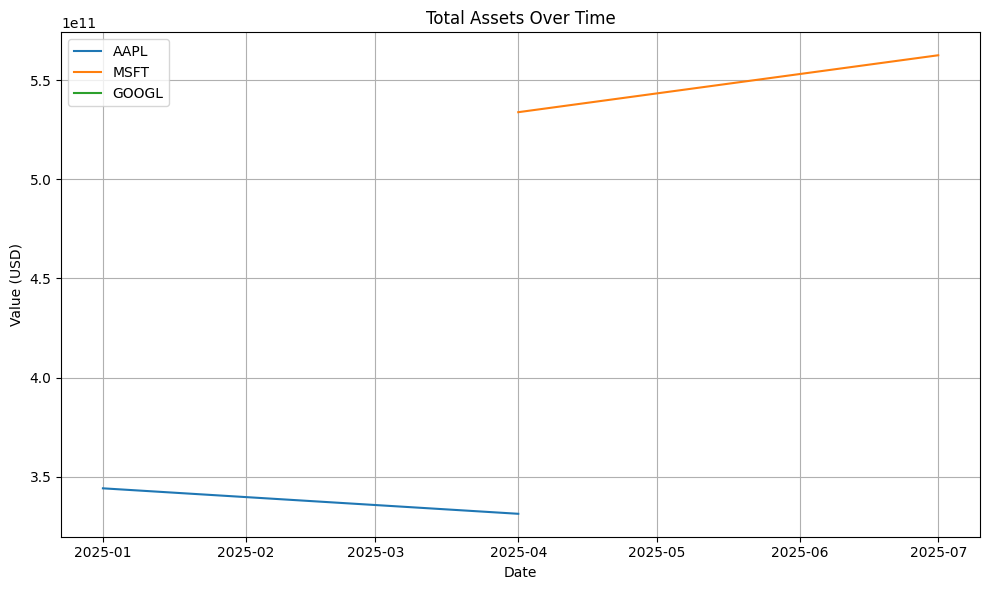

In [26]:
concept_filter = 'Total assets'
tickers = ['AAPL', 'MSFT', 'GOOGL']

df_assets = report[
    (report['label'].str.lower() == concept_filter.lower()) &
    (report['symbol'].isin(tickers)) &
    (report['statement'] == 'bs')
].copy()

# Convert year & quarter to datetime
df_assets['date'] = df_assets['year'].astype(str) + 'Q' + df_assets['quarter'].astype(str)
df_assets['date'] = pd.PeriodIndex(df_assets['date'], freq='Q').to_timestamp()

# Plotting
plt.figure(figsize=(10, 6))
for ticker in tickers:
    data = df_assets[df_assets['symbol'] == ticker].sort_values('date')
    plt.plot(data['date'], data['value'], label=ticker)

plt.title("Total Assets Over Time")
plt.xlabel("Date")
plt.ylabel("Value (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Consumption Task 3: IMF Indicators Visualization

In [28]:
indicators = bd.table("imf_indicators").df()
logging.info(f"Loaded {len(indicators)} IMF indicator entries.")
print(indicators)

Loaded 1020 IMF indicator entries.


      year      indicator    value
0     2002  USA_NGDP_RPCH    1.700
1     2019  USA_NGDP_RPCH    2.600
2     2014  USA_NGDP_RPCH    2.500
3     2009  USA_NGDP_RPCH   -2.600
4     2015  USA_NGDP_RPCH    2.900
...    ...            ...      ...
1015  1985         ESP_LP   38.792
1016  2024         USA_LP  340.102
1017  2008         ESP_LP   46.239
1018  1983         ESP_LP   38.502
1019  1990         ESP_LP   39.224

[1020 rows x 3 columns]


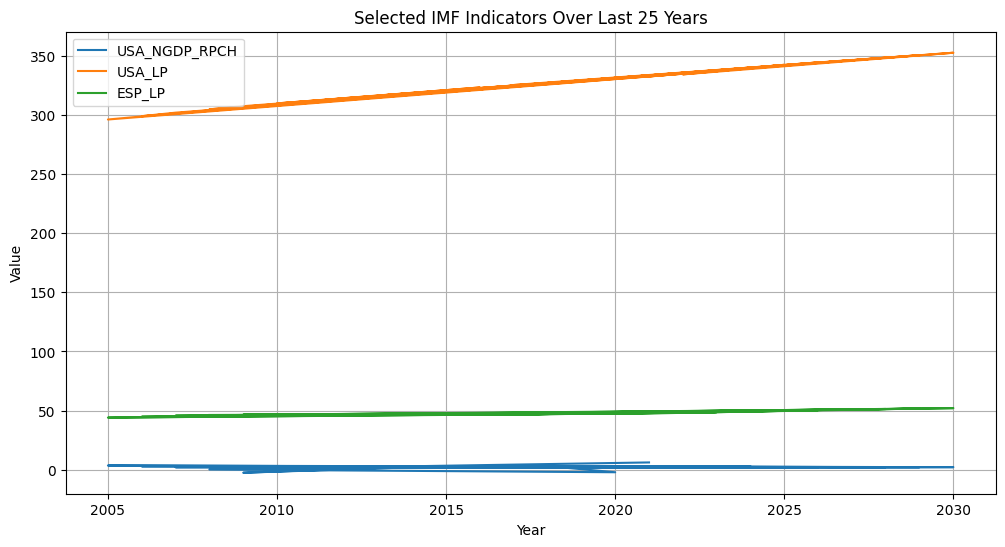

In [ ]:
# Filter to past 25 years
latest_year = indicators['year'].max()
indicators_filtered = indicators[indicators['year'] >= latest_year - 25]

chosen_indicators = ['USA_NGDP_RPCH', 'USA_LP', 'ESP_LP']
plt.figure(figsize=(12, 6))

for indicator in chosen_indicators:
    subset = indicators_filtered[indicators_filtered['indicator'] == indicator]
    plt.plot(subset['year'], subset['value'], label=indicator)

plt.title("Selected IMF Indicators Over Last 25 Years")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# NOT PART OF ANY CONSUPTION TASK, JUST SHOWING HOW TO ACCESS A TABLE
ops_metadata = bd.table("ops_db_kyc_metadata").df()
print(ops_metadata)

                              request_id  user_id  \
0   378e489c-dd76-4d6e-9c06-5d362916453c  AC00088   
1   cd80ae15-4a89-4f6f-93eb-687876482e63  AC00416   
2   91e4f611-82c7-4095-96b4-512556f2302e  AC00438   
3   53c4e3c3-366f-42c9-8adf-c3af39d72043  AC00024   
4   c67f0f25-de5c-487d-8148-6f0154cb26ee  AC00281   
..                                   ...      ...   
93  b71296fe-3164-42da-a966-b593be564dd4  AC00068   
94  82140e38-6ae1-46f5-a4cf-66e07c591552  AC00166   
95  9a1bef41-1a9a-4b64-b921-944f0381c040  AC00315   
96  d4438b22-adf2-4a44-a7ee-9d59c12d8e52  AC00367   
97  edb2b41d-b507-47d5-a970-0a56f32addb7  AC00345   

                                          doc_s3_path  \
0   s3a://unstructureddata/images/doc_378e489c-dd7...   
1   s3a://unstructureddata/images/doc_cd80ae15-4a8...   
2   s3a://unstructureddata/images/doc_91e4f611-82c...   
3   s3a://unstructureddata/images/doc_53c4e3c3-366...   
4   s3a://unstructureddata/images/doc_c67f0f25-de5...   
..                   

# Consumption Task 4: Machine Learning Classification on Transactions

In [33]:
ops_transactions = bd.table("ops_db_user_transactions").df()
logging.info(f"Loaded {len(ops_transactions)} transactions.")
print(ops_transactions)

Loaded 249 transactions.


                           transaction_id  user_id           timestamp  \
0    10b118ce-bff6-45a5-b7a6-38bb14e10124  AC00407 2023-12-29 16:38:21   
1    1f965572-5fce-4bff-b32f-bfe1e73e2fad  AC00190 2023-07-13 17:50:13   
2    28d44b01-013d-4dae-a076-538d1c6ac76e  AC00383 2023-11-15 18:56:02   
3    5a0c968e-b041-432d-a4c8-906af757a401  AC00479 2023-01-30 18:50:00   
4    5bec4d59-5c58-49d6-95e8-3a61b911966e  AC00026 2023-01-09 16:54:30   
..                                    ...      ...                 ...   
244  e637ba3f-856b-43d7-8a6f-4ac0ae3e7279  AC00134 2023-08-25 16:45:20   
245  86630999-b5fc-4905-bbcd-d1326398e52b  AC00115 2023-01-23 18:35:43   
246  cbd95003-2407-4850-a31c-53920c8cab28  AC00274 2023-11-08 17:24:54   
247  3212eaa9-1aee-4e70-8709-01c78206c7f2  AC00174 2023-08-11 17:57:52   
248  bd53fabf-c436-4eca-8cf0-4113f976da06  AC00032 2023-01-26 16:17:52   

       type  amount currency    description     location device_id  \
0     Debit  186.69      GBP  M015 - Bran

Preparing transaction classification dataset...
Data split: 199 training samples, 50 test samples.
Model trained.
Classification Report:

              precision    recall  f1-score   support

      Credit       0.00      0.00      0.00         6
       Debit       0.88      1.00      0.94        44

    accuracy                           0.88        50
   macro avg       0.44      0.50      0.47        50
weighted avg       0.77      0.88      0.82        50



c:\Users\ivanm\OneDrive\Documentos\GitHub\BDM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ivanm\OneDrive\Documentos\GitHub\BDM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ivanm\OneDrive\Documentos\GitHub\BDM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

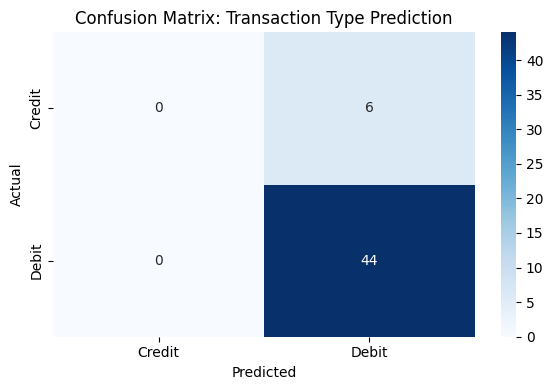

In [43]:
print("Preparing transaction classification dataset...")

# Select relevant columns
features = ['amount', 'account_balance', 'transaction_duration', 'login_attempts']
target = 'type'

df_txn = ops_transactions.dropna(subset=features + [target]).copy()

# Encode target label: Debit=0, Credit=1
le = LabelEncoder()
df_txn['type_encoded'] = le.fit_transform(df_txn['type'])

X = df_txn[features]
y = df_txn['type_encoded']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")

# Train a Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)
print("Model trained.")

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix: Transaction Type Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Consumption Task 5: Clustering on Profiles + Transactions

In [44]:
ops_profiles = bd.table("ops_db_user_profiles").df()
logging.info(f"Loaded {len(ops_profiles)} profiles.")
print(ops_profiles)

Loaded 283 profiles.


     user_id  age occupation
0    AC00061   79    Retired
1    AC00081   23    Student
2    AC00145   23    Student
3    AC00163   18    Student
4    AC00174   36   Engineer
..       ...  ...        ...
278  AC00284   70     Doctor
279  AC00161   41     Doctor
280  AC00229   73    Retired
281  AC00159   69    Retired
282  AC00349   56     Doctor

[283 rows x 3 columns]


In [ ]:
# Aggregate user-level features from transactions
agg = ops_transactions.groupby('user_id').agg({
    'amount': 'mean',
    'type': lambda x: x.mode()[0]  # most frequent type
}).reset_index().rename(columns={'amount': 'avg_amount', 'type': 'dominant_type'})

# Merge with profiles
merged = pd.merge(ops_profiles, agg, on='user_id')
merged = merged.dropna()

# Encode
merged_encoded = pd.get_dummies(merged.drop(columns='user_id'))

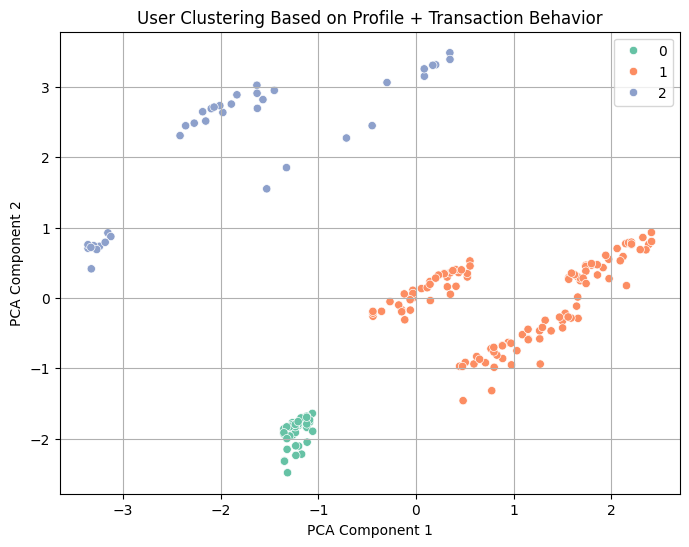

In [47]:
scaler = StandardScaler()
scaled = scaler.fit_transform(merged_encoded)

pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(components)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels, palette='Set2')
plt.title("User Clustering Based on Profile + Transaction Behavior")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
